# Homework 5

Implement a Kalman Filter to estimate the position and orientation of a vehicle from a GPS and an IMU. 
GPS provides global position information but can have accuracy issues due to signal obstructions and multipath errors.
IMU provides high-frequency acceleration and angular velocity measurements but suffers from drift over time. 
The idea is to fuse the data from these sensors and improve the accuracy and reliability of pose estimation for navigation applications.

The Data was collected from the NUANCE autonomous car and stored in a rosbag: https://drive.google.com/file/d/13NTbaSxY7uYbRrld7iVXB27czxcrRTL9/view?usp=drive_link 

We will use "/gps/fix" and "/imu/imu_uncompensated"

In [1]:
import bagpy
from bagpy import bagreader
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import geo_transforms
from scipy import integrate
import os
from extended_kalman_filter import ExtendedKalmanFilter as EKF
from utils import normalize_angles

# Save Bag file data
if (os.path.exists('2023-10-19-14-14-38-filtered/gps-fix.csv')):
    data_gps = "2023-10-19-14-14-38-filtered/gps-fix.csv"
    data_imu = "2023-10-19-14-14-38-filtered/imu-imu_uncompensated.csv"
else:
    b = bagreader('2023-10-19-14-14-38-filtered.bag')
    data_gps = b.message_by_topic('/gps/fix')
    data_imu = b.message_by_topic('/imu/imu_uncompensated')

First GPS Data: <br>
1697739552.3366451 sec, idx=2737 <br><br>
Last GPS Data: <br>
1697742219.9365995 sec, idx=29349

In [2]:
# Save GPS Data to Variables
gps_time = pd.read_csv(data_gps, index_col=0)
gps_lat = pd.read_csv(data_gps, index_col=7)
gps_lon = pd.read_csv(data_gps, index_col=8)

gps_data = np.array([gps_lon.index[:], gps_lat.index[:]])
origin = gps_data[:,2737]  # set the initial position to the origin
gt_trajectory_xyz = geo_transforms.lla_to_enu(gps_data, origin)

gps_x_all, gps_y_all, _ = gt_trajectory_xyz
gps_x = gps_x_all[np.logical_not(np.isnan(gps_x_all))]
gps_y = gps_y_all[np.logical_not(np.isnan(gps_y_all))]
gps_t = gps_time.index[np.logical_not(np.isnan(gps_x_all))]

In [3]:
# Save IMU Data to Variables
imu_time = pd.read_csv(data_imu, index_col=0)
ang_vel_x = pd.read_csv(data_imu, index_col=18)
ang_vel_y = pd.read_csv(data_imu, index_col=19)
ang_vel_z = pd.read_csv(data_imu, index_col=20)
lin_accel_x = pd.read_csv(data_imu, index_col=30)
lin_accel_y = pd.read_csv(data_imu, index_col=31)
lin_accel_z = pd.read_csv(data_imu, index_col=32)

imu_yr = ang_vel_z.index[54719:588367]
imu_grav = lin_accel_z.index[54719:588367]
imu_a_all = lin_accel_x.index[:]
imu_a_raw = list(lin_accel_x.index[54719:588367])
imu_a = np.copy(imu_a_raw)
imu_t = imu_time.index[54719:588367]

# IMU Acceleration Adjustment and Compensation
Use Gravity (IMU_Z) to find when the vehicle is stopped by comparing chunks of data. Save as stopped_iters variable

In [4]:
grav = list(imu_grav)

num_iters = 500
samples_per_iter = int(len(grav)/num_iters)

stopped_iters = []
start_iter = 0

for i in range(num_iters):

    if (all(np.abs(grav[ele] - grav[start_iter]) < 0.3 for ele in range(start_iter,start_iter+samples_per_iter))):
        for ii in range (samples_per_iter):
            stopped_iters.append(i*samples_per_iter + ii)

    start_iter += samples_per_iter

Subtract the difference from the average gravity from the IMU_X values to compensate for incline/decline during the drive

In [5]:
# Compensate for Incline/Decline using Gravity
grav_avg = np.average(imu_grav[:])
grav_diff = [imu_grav[i] - grav_avg for i in range(len(imu_grav))]

imu_a = [imu_a[i] - grav_diff[i] for i in range(len(imu_a))]

Offset Compensation by subtracting the average of the prior and current stopped acceleration, which should be a forward acceleration of zero. Apply this offset to each value in that range

In [6]:
imu_a = imu_a - np.average(imu_a)

for i in range(1,len(stopped_iters)):
    start_iter = stopped_iters[i-1]
    end_iter = stopped_iters[i]
    avg_a = (imu_a[start_iter] + imu_a[end_iter])/2
    imu_a[start_iter:end_iter] = imu_a[start_iter:end_iter] - avg_a

Chunk the acceleration data and zero the average across the drive

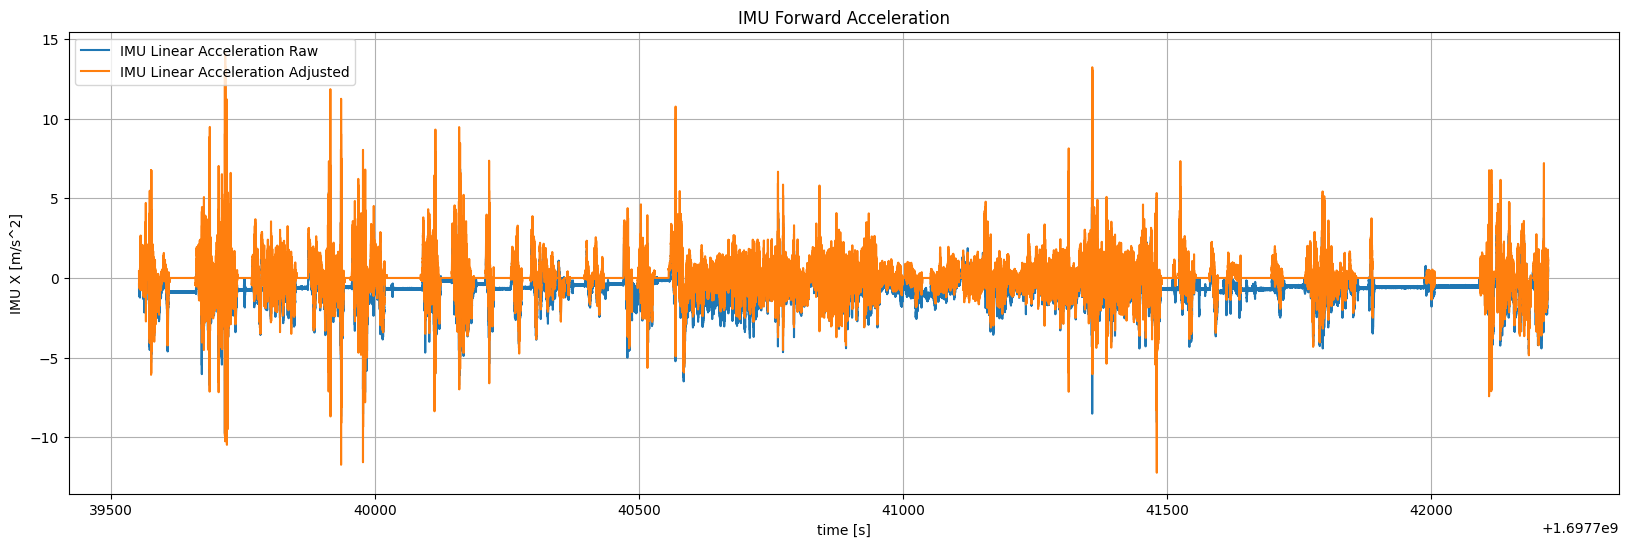

In [7]:
num_iters = 50
samples_per_iter = int(len(imu_a)/num_iters)
start_iter = 0

for i in range(1,num_iters):
    end_iter = start_iter + samples_per_iter

    imu_a_avg = np.average(imu_a[start_iter : end_iter])
    imu_a[start_iter : end_iter] = [imu_a[ii] - imu_a_avg for ii in range(start_iter, end_iter)]

    start_iter += samples_per_iter
    
imu_a[stopped_iters] = 0

fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(imu_t, imu_a_raw, label='IMU Linear Acceleration Raw')
ax.plot(imu_t, imu_a, label='IMU Linear Acceleration Adjusted')
ax.legend(loc="upper left")
ax.set_xlabel('time [s]')
ax.set_ylabel('IMU X [m/s^2]')
ax.set_title('IMU Forward Acceleration')
ax.grid()

# Estimate Forward Velocity from IMU Linear Acceleration Data
Using cumtrapz method for integration

Similar to Linear Acceleration, chunk the data into portions and set the minimum value to zero, since the vehicle was never put in reverse it should all be positive.

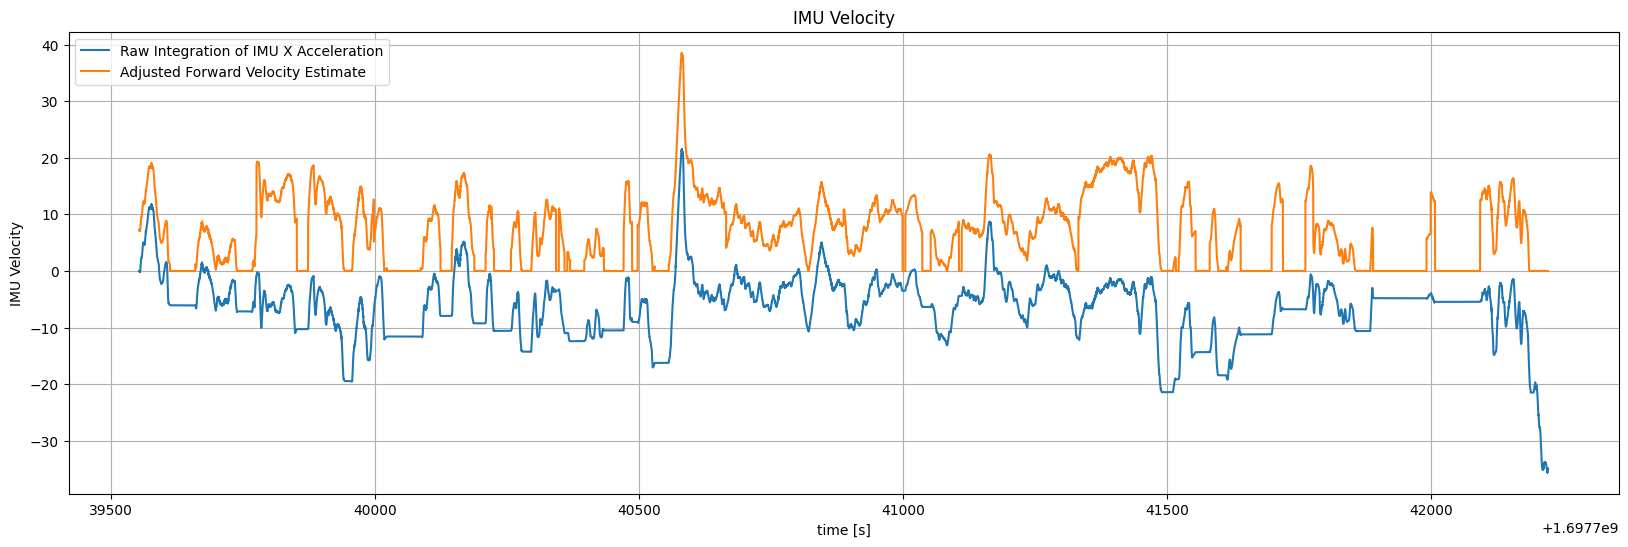

In [8]:
imu_v = integrate.cumtrapz(imu_a, imu_t)

imu_v_raw = np.copy(imu_v)

num_iters = 12
samples_per_iter = int(len(imu_v)/num_iters)
start_iter = 0

for i in range(1,num_iters):
    end_iter = start_iter + samples_per_iter

    imu_v_min = min(imu_v[start_iter : end_iter])
    imu_v[start_iter : end_iter] = [imu_v[ii] - imu_v_min for ii in range(start_iter, end_iter)]

    start_iter += samples_per_iter

imu_v_min = min(imu_v[end_iter : len(imu_v)])
imu_v[end_iter : len(imu_v)] = [imu_v[ii] - imu_v_min/2 for ii in range(end_iter, len(imu_v))]
imu_v[end_iter : len(imu_v)] = [0 if imu_v[i] < 0 else imu_v[i] for i in range(end_iter, len(imu_v))]

imu_v[stopped_iters] = 0

fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(imu_t[1:], imu_v_raw, label='Raw Integration of IMU X Acceleration')
ax.plot(imu_t[1:], imu_v, label='Adjusted Forward Velocity Estimate')
ax.legend(loc="upper left")
ax.set_xlabel('time [s]')
ax.set_ylabel('IMU Velocity')
ax.set_title('IMU Velocity')
ax.grid()

Plot GPS Velocity Estimate

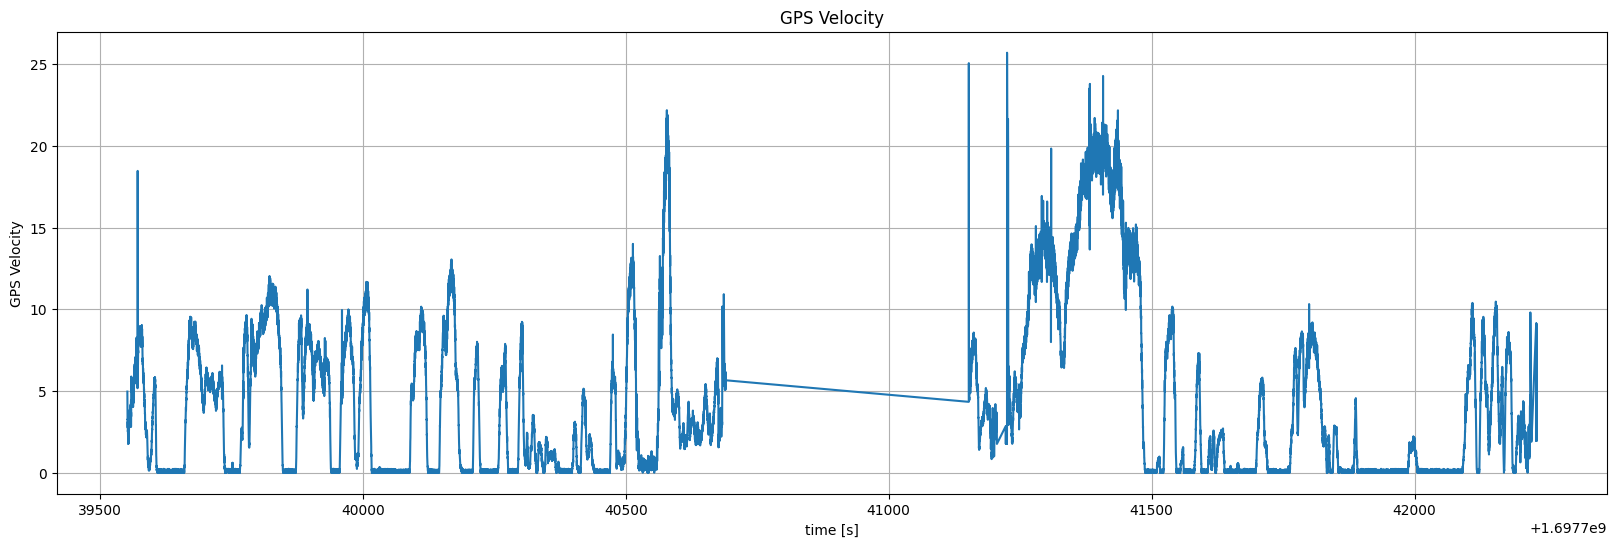

In [9]:
# GPS Velocity
gps_v = []
for i in range(1, len(gps_x)):
    t_diff = gps_t[i] - gps_t[i-1]
    gps_x_diff = gps_x[i] - gps_x[i-1]
    gps_y_diff = gps_y[i] - gps_y[i-1]
    gps_v_ = np.sqrt(gps_x_diff**2 + gps_y_diff**2)/ t_diff

    if (gps_v_ > 30): 
        gps_v_ = gps_v[-2]

    gps_v.append(gps_v_)

fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(gps_t[1:], gps_v)
ax.set_xlabel('time [s]')
ax.set_ylabel('GPS Velocity')
ax.set_title('GPS Velocity')
ax.grid()

# IMU Dead Reckoning

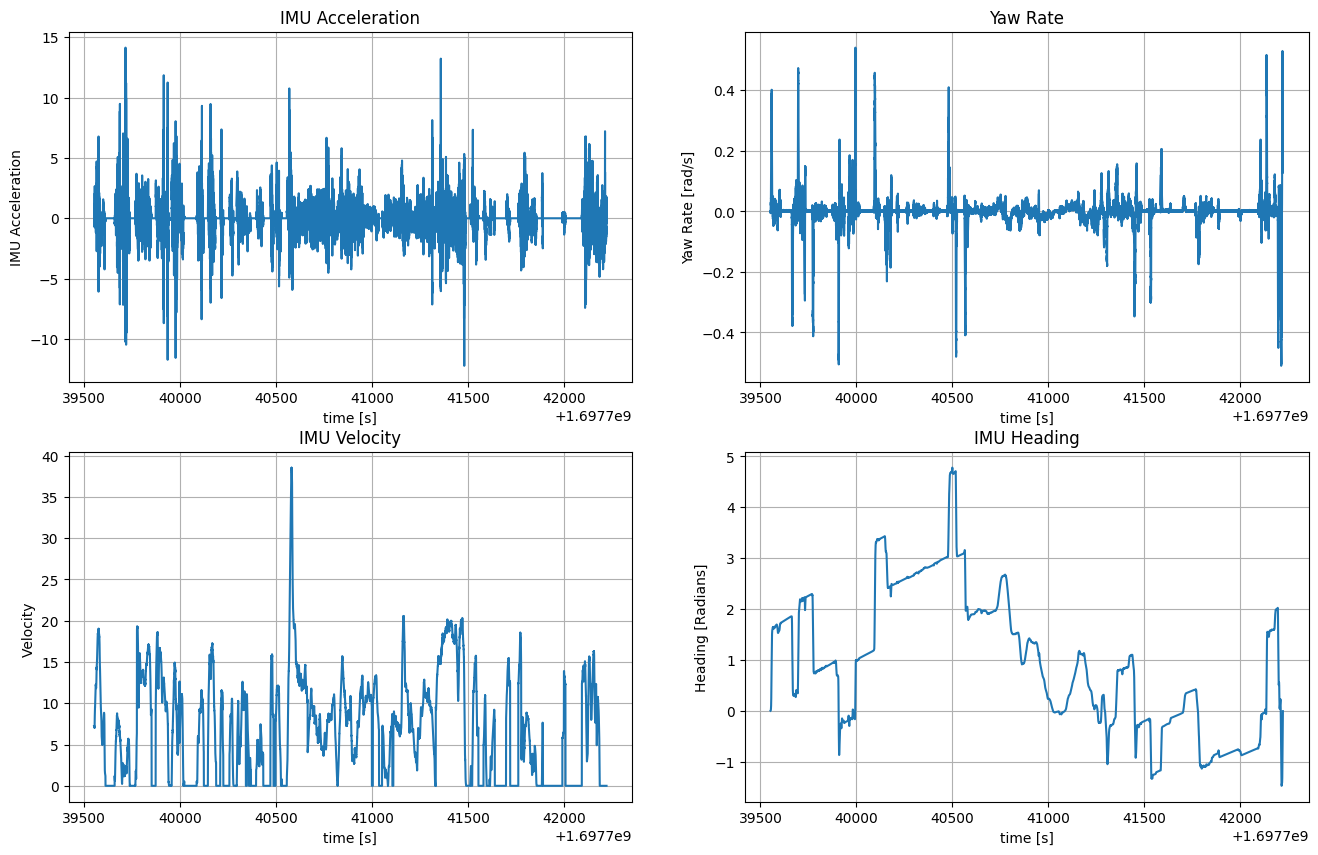

In [10]:
time0 = imu_t[0]

ang_vel = imu_yr - np.mean(imu_yr)

yaw_angle = integrate.cumtrapz(ang_vel, imu_t)

px = []
py = []

for i in range(1, len(imu_t)-1):
    dt = imu_t[i] - time0
    time0 = imu_t[i]

    px.append(-imu_v[i] * np.cos(yaw_angle[i]))
    py.append(imu_v[i] * np.sin(yaw_angle[i]))

imu_pE = integrate.cumtrapz(px, imu_t[2:])
imu_pN = integrate.cumtrapz(py, imu_t[2:])

fig, ax = plt.subplots(2, 2, figsize=(16, 10))
ax[0,0].plot(imu_t, imu_a)
ax[0,0].set_xlabel('time [s]')
ax[0,0].set_ylabel('IMU Acceleration')
ax[0,0].set_title('IMU Acceleration')
ax[0,0].grid()
ax[1,0].plot(imu_t[1:], imu_v)
ax[1,0].set_xlabel('time [s]')
ax[1,0].set_ylabel('Velocity ')
ax[1,0].set_title('IMU Velocity')
ax[1,0].grid()
ax[0,1].plot(imu_t, ang_vel)
ax[0,1].set_xlabel('time [s]')
ax[0,1].set_ylabel('Yaw Rate [rad/s]')
ax[0,1].set_title('Yaw Rate')
ax[0,1].grid()
ax[1,1].plot(imu_t[1:], yaw_angle)
ax[1,1].set_xlabel('time [s]')
ax[1,1].set_ylabel('Heading [Radians]')
ax[1,1].set_title('IMU Heading')
ax[1,1].grid()

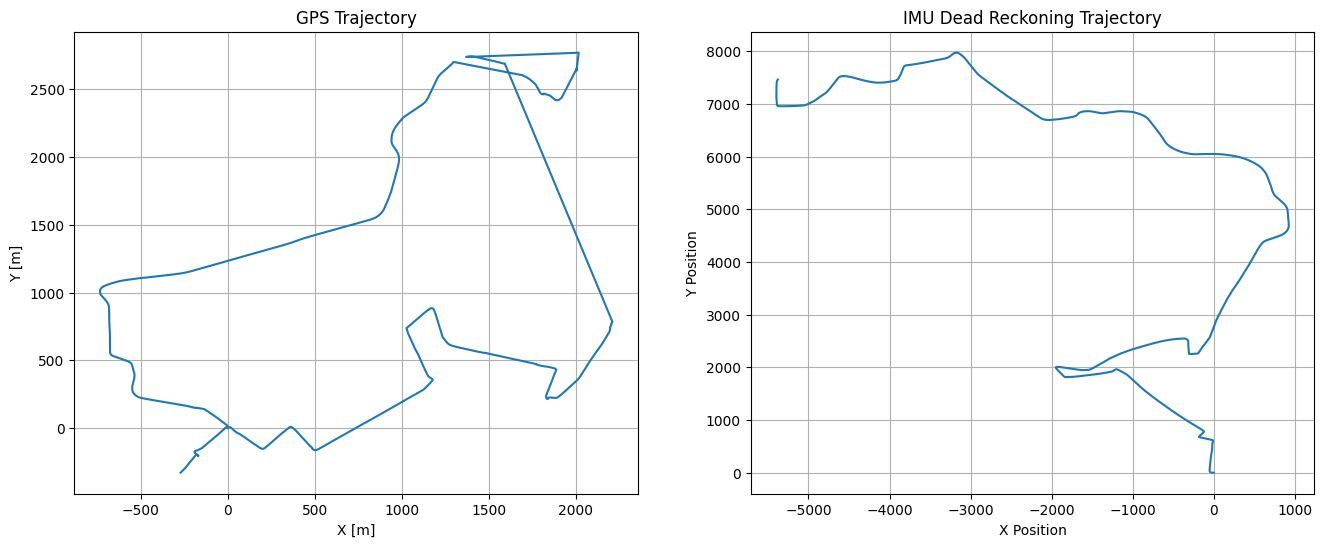

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
ax[0].plot(gps_x, gps_y)
ax[0].set_xlabel('X [m]')
ax[0].set_ylabel('Y [m]')
ax[0].set_title('GPS Trajectory')
ax[0].grid()

# Plot the dead reckoning trajectory
ax[1].plot(imu_pE, imu_pN)
ax[1].set_xlabel('X Position')
ax[1].set_ylabel('Y Position')
ax[1].set_title('IMU Dead Reckoning Trajectory')
ax[1].grid()

# Kalman Filter Implementation
Code up the Kalman Filter to compute pose estimates using Python.
Define and write up the equations for your process and measurement models, their covariances, and parameters in the Jupyter Notebook.
Define and report the initial conditions, as well. Develop functions for prediction and correction steps and estimate the state iteratively.

Implement a kalman filter to estimate 2D (x, y, theta) pose of the vehicle by fusing GPS and IMU measurements. Use constant-velocity model for IMU or include acceleration component.

Ignore computer accelerometer and gyroscope biases. Estimate them initially by averaging the readings at rest and subtracting them from your readings to unbias the measurements. Assume constant biases.

The process model, measurement model, and covariance update equations must be programmed independently. 

### Prepare initial estimate and its error covariance

Suppose initial 2d position [x, y] estimation are initialized with the first GPS observation.

Since our vehicle has no sensor to measure yaw angle, yaw estimation is initialized randomly and its variance is initialized with some large value (e.g. pi).

In [12]:
# Noise Def
xy_obs_noise_std = 5.0  # standard deviation of observation noise of x and y in meter
yaw_rate_noise_std = 0.02 # standard deviation of yaw rate in rad/s
forward_velocity_noise_std = 0.3 # standard deviation of forward velocity in m/s

In [13]:
# initial state x_0
initial_yaw_std = np.pi
initial_yaw = yaw_angle[0] + np.random.normal(0, initial_yaw_std)

x = np.array([
    gps_x[0],
    gps_y[0],
    initial_yaw
])

In [14]:
# covariance for initial state estimation error (Sigma_0)
P = np.array([
    [xy_obs_noise_std ** 2., 0., 0.],
    [0., xy_obs_noise_std ** 2., 0.],
    [0., 0., initial_yaw_std ** 2.]
])

### Prepare measuerment error covariance Q

In [15]:
Q = np.array([
    [xy_obs_noise_std ** 2., 0.],
    [0., xy_obs_noise_std ** 2.]
])

### Prepare state transition noise covariance R

In [16]:
R = np.array([
    [forward_velocity_noise_std ** 2., 0., 0.],
    [0., forward_velocity_noise_std ** 2., 0.],
    [0., 0., yaw_rate_noise_std ** 2.]
])

### Kalman filter main routine

In [17]:
N = len(imu_t)  # number of data point

# initialize Kalman filter
kf = EKF(x, P)

# array to store estimated 2d pose [x, y, theta]
mu_x = [x[0],]
mu_y = [x[1],]
mu_theta = [x[2],]

# array to store estimated error variance of 2d pose
var_x = [P[0, 0],]
var_y = [P[1, 1],]
var_theta = [P[2, 2],]

t_last = 0.
gps_idx = 0
t_last = gps_t[gps_idx]

for t_idx in range(1, N-1):
    dt = imu_t[t_idx] - imu_t[t_idx - 1]
    
    # get control input `u = [v, omega] + noise`
    u = np.array([
        imu_v[t_idx],
        -ang_vel[t_idx]
    ])
    
    # because velocity and yaw rate are multiplied with `dt` in state transition function,
    # its noise covariance must be multiplied with `dt**2.`
    R_ = R * (dt ** 2.)
    
    # propagate!
    kf.propagate(u, dt, R)
    
    # Only update when a gps measurement is acquired
    if (imu_t[t_idx] > t_last):
        # get measurement `z = [x, y] + noise`
        z = np.array([
            gps_x[gps_idx],
            gps_y[gps_idx]
        ])
        
        # update!
        kf.update(z, Q)

        gps_idx += 1

        t_last = gps_t[gps_idx]
    
    # save estimated state to analyze later
    mu_x.append(kf.x[0])
    mu_y.append(kf.x[1])
    mu_theta.append(normalize_angles(kf.x[2]))
    
    # save estimated variance to analyze later
    var_x.append(kf.P[0, 0])
    var_y.append(kf.P[1, 1])
    var_theta.append(kf.P[2, 2])
    
mu_x = np.array(mu_x)
mu_y = np.array(mu_y)
mu_theta = np.array(mu_theta)

var_x = np.array(var_x)
var_y = np.array(var_y)
var_theta = np.array(var_theta)

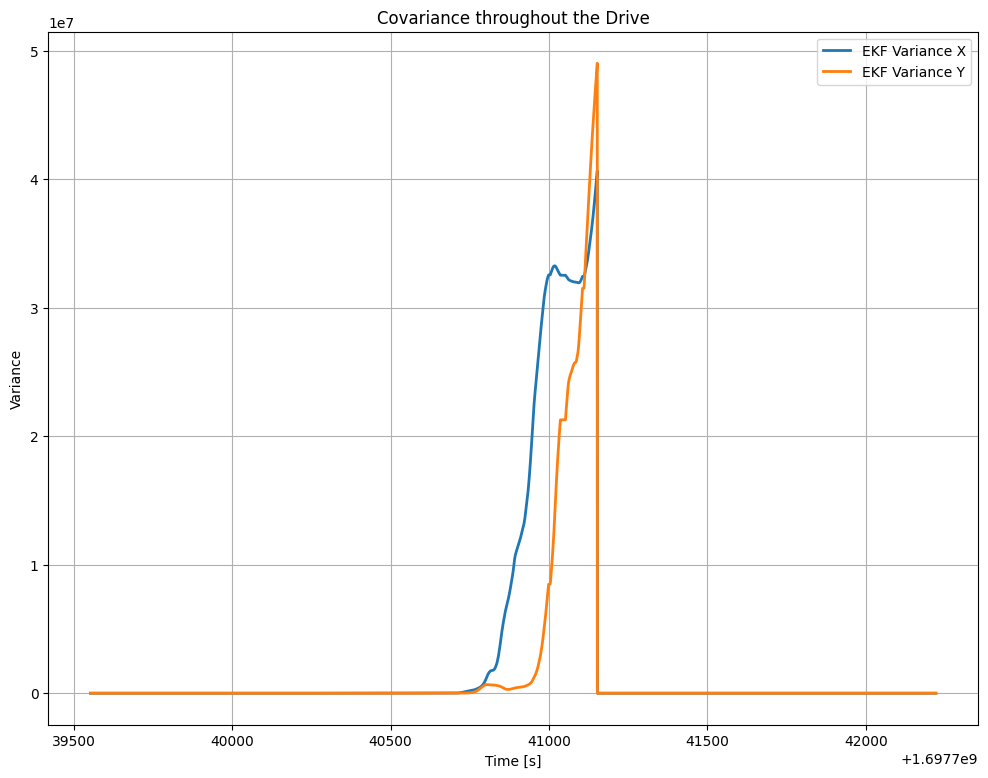

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(12, 9))

xs, ys, _ = gt_trajectory_xyz

ax.plot(imu_t[1:], var_x, lw=2, label='EKF Variance X')
ax.plot(imu_t[1:], var_y, lw=2, label='EKF Variance Y')

ax.set_title("Covariance throughout the Drive")
ax.set_xlabel('Time [s]')
ax.set_ylabel('Variance')
ax.legend()
ax.grid()


It is important to note that the increase in covariance is directly corresponding to the loss of GPS data when going through tunnels

## Visualize estimated results

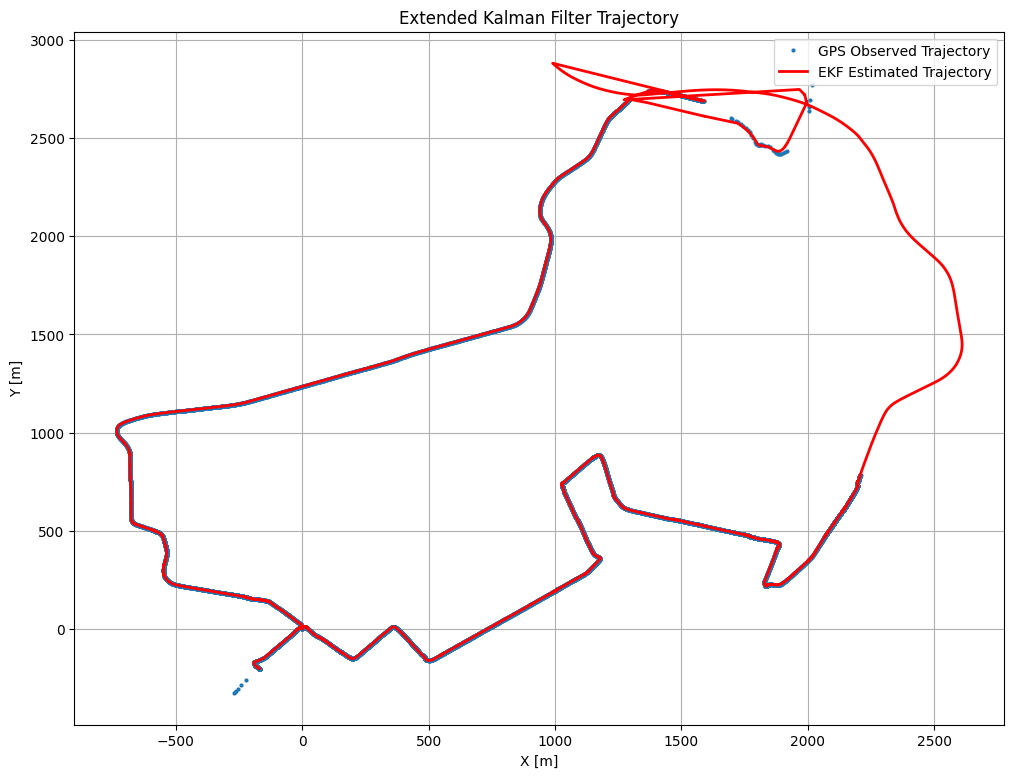

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(12, 9))

xs, ys, _ = gt_trajectory_xyz
ax.plot(xs, ys, lw=0, marker='.', markersize=4, alpha=1., label='GPS Observed Trajectory')
ax.plot(mu_x, mu_y, lw=2, label='EKF Estimated Trajectory', color='r')

ax.set_title("Extended Kalman Filter Trajectory")
ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')
ax.legend()
ax.grid()